# KLUE Relation Extraction - 학습 및 성능 개선

이 노트북은 **학습 기반 베이스라인**을 구축하고, **개선 실험 1개**를 추가하여 성능 차이를 비교합니다.

## 목표
- Baseline: KLUE-RoBERTa base 파인튜닝
- Improvement: 클래스 불균형 대응(예: class weights) 또는 입력 포맷 개선 중 1개 적용
- 평가 지표: **Macro F1 중심**, Micro F1/Accuracy 참고

## 1. 환경 설정

In [1]:
# 필요 라이브러리
import os
import random
import numpy as np
import pandas as pd

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

# transformers
import importlib.util as _importlib_util
import sys as _sys

def _disable_torchvision():
    _sys.modules.pop("torchvision", None)
    _orig_find_spec = _importlib_util.find_spec
    def _patched_find_spec(name, *args, **kwargs):
        if name == "torchvision":
            return None
        return _orig_find_spec(name, *args, **kwargs)
    _importlib_util.find_spec = _patched_find_spec

try:
    import torchvision  # noqa: F401
    _ = torchvision.ops.nms
except Exception:
    _disable_torchvision()

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

# torch
import torch
from torch.utils.data import Dataset

## 2. 재현성 설정

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## 3. 데이터 로드 및 전처리

In [3]:
# 02번 노트북에서 생성한 전처리 결과 사용
train_path = 'data/klue_re_train_processed.csv'
valid_path = 'data/klue_re_valid_processed.csv'

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

# label 컬럼명이 notebook마다 달라서 통일
if 'label_id' not in train_df.columns and 'label' in train_df.columns:
    train_df['label_id'] = train_df['label']
if 'label_id' not in valid_df.columns and 'label' in valid_df.columns:
    valid_df['label_id'] = valid_df['label']


print(train_df.head())
print('Train:', len(train_df), 'Valid:', len(valid_df))

                     guid                                         input_text  \
0  klue-re-v1_train_00000  〈Something〉는 [OBJ]조지 해리슨[/OBJ]이 쓰고 [SUBJ]비틀즈[/...   
1  klue-re-v1_train_00001  호남이 기반인 바른미래당·[OBJ]대안신당[/OBJ]·[SUBJ]민주평화당[/SUB...   
2  klue-re-v1_train_00002  K리그2에서 성적 1위를 달리고 있는 [SUBJ]광주FC[/SUBJ]는 지난 26일...   
3  klue-re-v1_train_00003  균일가 생활용품점 (주)[SUBJ]아성다이소[/SUBJ](대표 [OBJ]박정부[/O...   
4  klue-re-v1_train_00004  [OBJ]1967[/OBJ]년 프로 야구 드래프트 1순위로 [SUBJ]요미우리 자이...   

   label  label_id  
0      0         0  
1      0         0  
2      5         5  
3     10        10  
4      0         0  
Train: 32470 Valid: 7765


## 4. 데이터셋 클래스 정의

In [4]:
MODEL_NAME = 'klue/roberta-base'
MAX_LEN = 256

class KLUEREDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df['input_text'].tolist()
        self.labels = df['label_id'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

## 5. Baseline 학습

In [5]:
# 토크나이저/모델 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=30)

train_dataset = KLUEREDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = KLUEREDataset(valid_df, tokenizer, MAX_LEN)

# 평가 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    micro_f1 = f1_score(labels, preds, average='micro')
    return {'accuracy': acc, 'macro_f1': macro_f1, 'micro_f1': micro_f1}

training_args = TrainingArguments(
    output_dir='temp_result/06_klue_re_training/baseline',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

# 학습 실행
from transformers.trainer_utils import get_last_checkpoint
baseline_ckpt = get_last_checkpoint(training_args.output_dir)
if baseline_ckpt is None:
    trainer.train()
else:
    print(f'Found checkpoint: {baseline_ckpt}. Skip training.')


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: klue/roberta-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.bias           | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Found checkpoint: temp_result/06_klue_re_training/baseline/checkpoint-3045. Skip training.


## 6. 성능 개선 실험

In [8]:
# 개선안 예시: 클래스 가중치 적용
# 참고: transformers Trainer에 loss 가중치 적용하려면 Custom Trainer 필요

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 클래스 분포로 가중치 계산
label_counts = train_df['label_id'].value_counts().sort_index()
class_weights = 1.0 / torch.tensor(label_counts.values, dtype=torch.float)
class_weights = class_weights / class_weights.mean()
class_weights = class_weights.to(model.device)

weighted_trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

# 개선 학습 실행
weighted_trainer.train()

/home/ai/jyk/ezcaretec/.localvenv/lib/python3.12/site-packages/torch/autograd/function.py:583: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  return super().apply(*args, **kwargs)  # type: ignore[misc]


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Micro F1
1,0.864307,1.243404,0.386349,0.357925,0.386349
2,0.587966,1.108954,0.527366,0.453830,0.527366
3,0.515118,1.069854,0.594720,0.503997,0.594720


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ai/jyk/ezcaretec/.localvenv/lib/python3.12/site-packages/torch/autograd/function.py:583: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  return super().apply(*args, **kwargs)  # type: ignore[misc]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/ai/jyk/ezcaretec/.localvenv/lib/python3.12/site-packages/torch/autograd/function.py:583: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  return super().apply(*args, **kwargs)  # type: ignore[misc]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=3045, training_loss=0.885731530150365, metrics={'train_runtime': 1282.1505, 'train_samples_per_second': 75.974, 'train_steps_per_second': 2.375, 'total_flos': 1.281804560704512e+16, 'train_loss': 0.885731530150365, 'epoch': 3.0})

## 성능검토 체크리스트
- 학습/검증 데이터 분리 및 누수 여부 확인
- 재현성(Seed 고정) 확인
- 기본 지표(accuracy, macro/micro F1) 확인
- 클래스별 F1 및 불균형 영향 확인
- 혼동행렬로 오분류 패턴 확인
- 오분류 샘플 점검(문장/라벨)
- 결과물 저장(지표/표/그래프)


/home/ai/jyk/ezcaretec/.localvenv/lib/python3.12/site-packages/torch/autograd/function.py:583: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  return super().apply(*args, **kwargs)  # type: ignore[misc]


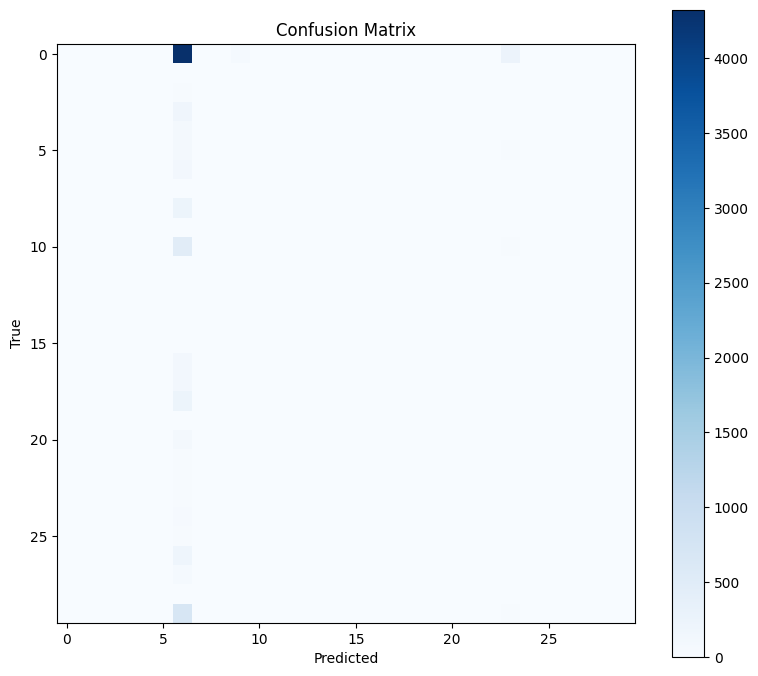

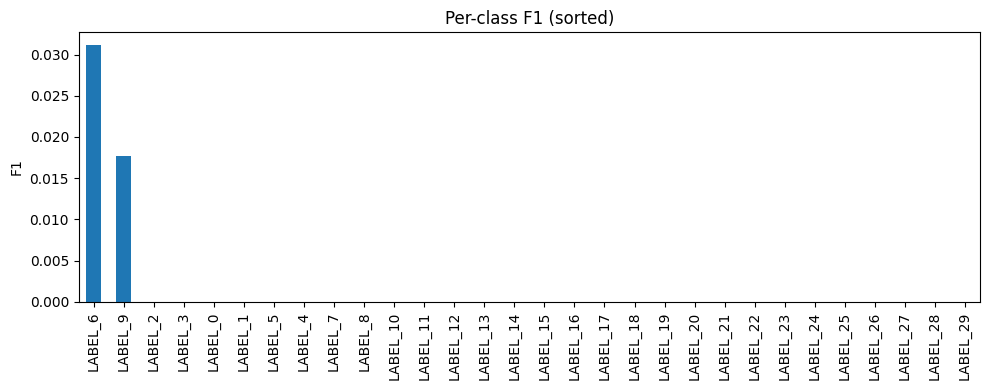

Saved eval artifacts to: temp_result/06_klue_re_training/eval_weighted


In [7]:
# 성능검토: 지표/표/그래프 저장
import json
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pathlib import Path
from transformers.trainer_utils import get_last_checkpoint

# compute_metrics가 없다면 간단 버전 정의
if 'compute_metrics' not in globals():
    from sklearn.metrics import f1_score, accuracy_score
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, preds)
        macro_f1 = f1_score(labels, preds, average='macro')
        micro_f1 = f1_score(labels, preds, average='micro')
        return {'accuracy': acc, 'macro_f1': macro_f1, 'micro_f1': micro_f1}

def _find_latest_checkpoint(root_dir):
    ckpt = get_last_checkpoint(root_dir)
    if ckpt:
        return ckpt
    root = Path(root_dir)
    candidates = [p for p in root.glob('checkpoint-*') if p.is_dir()]
    if not candidates:
        return None
    def _step(p):
        try:
            return int(p.name.split('-')[-1])
        except Exception:
            return -1
    return str(sorted(candidates, key=_step)[-1])

# baseline/weighted 중 존재하는 트레이너 선택
if 'weighted_trainer' in globals():
    eval_trainer = globals()['weighted_trainer']
    eval_tag = 'weighted'
elif 'trainer' in globals():
    eval_trainer = globals()['trainer']
    eval_tag = 'baseline'
else:
    ckpt_root = 'temp_result/06_klue_re_training/baseline'
    ckpt_path = _find_latest_checkpoint(ckpt_root)
    if ckpt_path is None:
        raise RuntimeError('No trainer found and no checkpoint in temp_result. Run training first.')
    eval_tag = f"baseline_{Path(ckpt_path).name}"
    eval_model = AutoModelForSequenceClassification.from_pretrained(ckpt_path)
    if 'training_args' in globals():
        eval_args = training_args
    else:
        eval_args = TrainingArguments(
            output_dir=ckpt_root,
            per_device_eval_batch_size=16,
            eval_strategy='no',
            logging_strategy='no',
            report_to=[],
        )
    eval_trainer = Trainer(
        model=eval_model,
        args=eval_args,
        eval_dataset=valid_dataset,
        compute_metrics=compute_metrics,
    )
eval_output_dir = f'temp_result/06_klue_re_training/eval_{eval_tag}'
os.makedirs(eval_output_dir, exist_ok=True)

# 예측 수행
pred_output = eval_trainer.predict(valid_dataset)
logits = pred_output.predictions
labels = pred_output.label_ids
preds = np.argmax(logits, axis=-1)

# 요약 지표 저장
summary = compute_metrics((logits, labels))
summary['num_samples'] = int(len(labels))
summary['num_labels'] = int(getattr(model.config, 'num_labels', len(np.unique(labels))))
with open(os.path.join(eval_output_dir, 'metrics_summary.json'), 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

# 라벨 이름 구성
num_labels = int(getattr(model.config, 'num_labels', len(np.unique(labels))))
id2label = getattr(model.config, 'id2label', None)
if isinstance(id2label, dict) and len(id2label) >= num_labels:
    label_names = [str(id2label.get(i, id2label.get(str(i), i))) for i in range(num_labels)]
else:
    label_names = [str(i) for i in range(num_labels)]

# 클래스별 성능
report_dict = classification_report(
    labels, preds,
    labels=list(range(num_labels)),
    target_names=label_names,
    output_dict=True,
    zero_division=0,
)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(eval_output_dir, 'per_class_report.csv'), encoding='utf-8')

# 혼동행렬 저장
cm = confusion_matrix(labels, preds, labels=list(range(num_labels)))
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)
cm_df.to_csv(os.path.join(eval_output_dir, 'confusion_matrix.csv'), encoding='utf-8')

# 혼동행렬 시각화
plt.figure(figsize=(8, 7))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(eval_output_dir, 'confusion_matrix.png'), dpi=150)
plt.show()

# 클래스별 F1 시각화
if all(name in report_df.index for name in label_names):
    f1_series = report_df.loc[label_names, 'f1-score']
    f1_series = f1_series.sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    f1_series.plot(kind='bar')
    plt.title('Per-class F1 (sorted)')
    plt.ylabel('F1')
    plt.tight_layout()
    plt.savefig(os.path.join(eval_output_dir, 'per_class_f1.png'), dpi=150)
    plt.show()

# 오분류 샘플 저장
err_df = valid_df.copy()
err_df['pred'] = preds
err_df['correct'] = err_df['label_id'] == err_df['pred']
err_cols = [c for c in ['guid', 'input_text', 'label_id', 'pred'] if c in err_df.columns]
err_df.loc[~err_df['correct'], err_cols].to_csv(
    os.path.join(eval_output_dir, 'error_samples.csv'),
    index=False,
    encoding='utf-8'
)

print('Saved eval artifacts to:', eval_output_dir)
